# Causal Inference Analysis on Wine Quality Dataset

**Author:** Chen Yang  
**NUID:** 002837912  

---

## Introduction

This notebook presents a causal inference analysis on the Wine Quality dataset (red wine) from the UCI Repository. The analysis aims to estimate the effect of high alcohol content (our treatment variable) on wine quality (the outcome). To achieve this, we perform the following steps:

1. **Data Loading and Preparation:**  
   Load the dataset, clean the column names, and create a binary treatment variable based on whether the alcohol content is above the median.

2. **Feature Selection:**  
   - Visualize the correlation matrix among variables.  
   - Use Lasso regression for automatic feature selection (as a data-driven complement to domain knowledge).

3. **DAG Construction:**  
   Build and visualize a Directed Acyclic Graph (DAG) using NetworkX to outline our assumed causal relationships between the treatment, outcome, and selected covariates.

4. **Causal Effect Estimation:**  
   Estimate the causal effect using OLS regression, including the treatment and the selected covariates.

5. **Result Visualization:**  
   Generate plots to compare the outcome distribution across treatment groups and display the causal DAG.

This notebook demonstrates how combining feature selection, causal assumptions (via a DAG), and regression modeling can be used for causal inference in observational data.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns

# Step 1: Load and Prepare the Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine = pd.read_csv(url, sep=';')
wine.columns = [col.replace(' ', '_') for col in wine.columns]  # remove spaces in column names

print("First few rows of the dataset:")
print(wine.head())
print("\nDataset information:")
print(wine.info())

# Create a treatment variable: high alcohol content (1 if above median, else 0)
median_alcohol = wine['alcohol'].median()
wine['high_alcohol'] = (wine['alcohol'] > median_alcohol).astype(int)
print("\nMedian alcohol value:", median_alcohol)
print("Treatment variable 'high_alcohol' distribution:")
print(wine['high_alcohol'].value_counts())

First few rows of the dataset:
   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8 

## Code Explanation above

1. **Importing Libraries**  
   The code begins by importing the necessary libraries:
   - `pandas` and `numpy` for data manipulation.
   - `matplotlib.pyplot` and `seaborn` for data visualization.
   - `statsmodels.formula.api` for running regression models.

2. **Loading the Data**  
   - The dataset is downloaded from the UCI repository using `pd.read_csv()`.  
   - The CSV file uses a semicolon (`;`) as a delimiter, which is specified with `sep=';'`.

3. **Cleaning Column Names**  
   - The column names are cleaned by replacing any spaces with underscores.  
   - This prevents issues later when referencing column names in formulas.

4. **Displaying Data**  
   - `wine.head()` is used to display the first few rows of the dataset, providing an initial look at the data.
   - `wine.info()` prints out detailed information about the dataset, such as the number of entries, data types, and non-null counts.

5. **Creating a Treatment Variable**  
   - The median value of the `alcohol` column is computed using `wine['alcohol'].median()`.
   - A new binary column `high_alcohol` is created:
     - It is set to `1` if the `alcohol` value is greater than the median.
     - Otherwise, it is set to `0`.
   - The median value and the distribution of the `high_alcohol` variable are printed to verify the creation of the treatment variable.

## Output Explanation

- **First Few Rows of the Dataset:**  
  The printed output shows the first 5 rows with columns like `fixed_acidity`, `volatile_acidity`, `citric_acid`, `residual_sugar`, `chlorides`, etc.  
  For example, the first row shows:
  - `fixed_acidity`: 7.4  
  - `volatile_acidity`: 0.70  
  - `citric_acid`: 0.00  
  - `residual_sugar`: 1.9  
  - `alcohol`: 9.4  
  - `quality`: 5  
  This output helps verify that the data has been loaded correctly.

- **Dataset Information:**  
  The output from `wine.info()` confirms that:
  - The dataset contains 1599 entries.
  - It displays details about each column (such as data type and number of non-null entries).
  This information is critical to ensure that the dataset is correctly structured and ready for further analysis.

- **Creation of the Treatment Variable:**  
  - The median alcohol value is printed (e.g., 9.4 or 9.8, as per the dataset's distribution).
  - The distribution printed by `wine['high_alcohol'].value_counts()` shows:
    - `0`: 842 instances (indicating low alcohol content).
    - `1`: 757 instances (indicating high alcohol content).
  This confirms that the new treatment variable (`high_alcohol`) has been successfully created and shows a reasonable balance between the two groups.

Overall, this chunk of code sets the foundation for the analysis by ensuring that the data is properly loaded, cleaned, and that the key treatment variable for the causal inference analysis is defined.


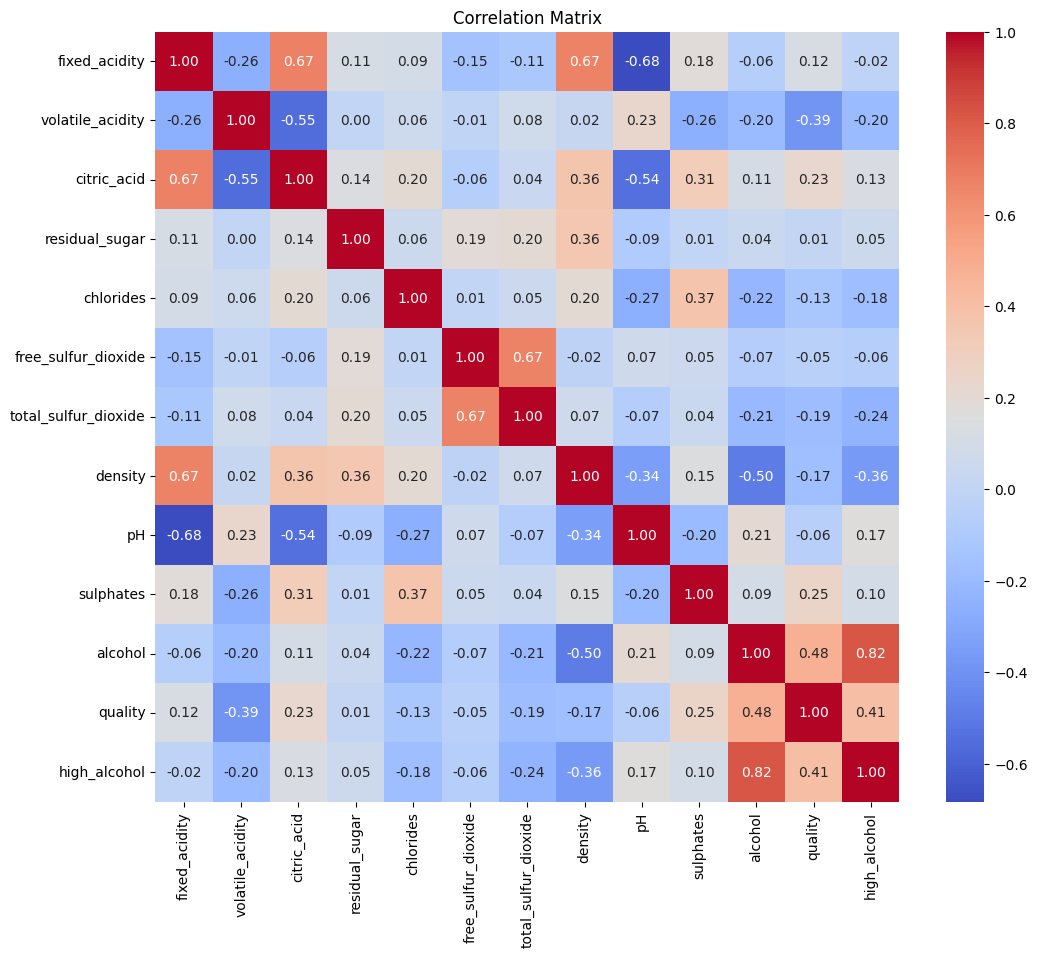


Lasso selected features and coefficients:
fixed_acidity           0.297322
sulphates               0.213194
residual_sugar          0.133033
pH                      0.095254
free_sulfur_dioxide     0.038685
citric_acid             0.009025
chlorides              -0.107116
total_sulfur_dioxide   -0.127669
volatile_acidity       -0.176310
density                -0.353875
dtype: float64


In [16]:
# Step 2: Feature Selection
# 2a. Visualize a correlation matrix to see relationships among variables
plt.figure(figsize=(12, 10))
corr = wine.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# 2b. Automatic Feature Selection using Lasso
#    (Note: This is just one data-driven approach; in causal inference, domain knowledge is essential.)
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Prepare features: Exclude outcome, treatment, and alcohol (since alcohol is used to create treatment)
features = wine.drop(columns=['quality', 'alcohol', 'high_alcohol'])
target = wine['quality']

# Standardize features for Lasso
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, target)
coef = pd.Series(lasso.coef_, index=features.columns)
print("\nLasso selected features and coefficients:")
print(coef.sort_values(ascending=False))

## Code Explanation above

1. **Correlation Matrix (2a)**  
   - We calculate the correlation matrix with `wine.corr()`.  
   - The `sns.heatmap()` function then visualizes these correlations in a heatmap, using a color scale (`cmap='coolwarm'`) to indicate the strength and direction of each correlation.
   - By inspecting this matrix, we can identify pairs of variables that have strong positive or negative relationships, guiding us in understanding potential confounders or redundant features.

2. **Automatic Feature Selection using Lasso (2b)**  
   - **Data Preparation:**  
     - We separate the dataset into `features` (all columns except `quality`, `alcohol`, and `high_alcohol`) and the `target` (the `quality` column).
   - **Standardization:**  
     - A `StandardScaler` is used to scale the features. Lasso (and many other regularization methods) typically perform better when features are on a comparable scale.
   - **LassoCV:**  
     - We use `LassoCV(cv=5, random_state=0)`, which performs Lasso regularization with 5-fold cross-validation to find an optimal regularization strength.
     - The model’s coefficients (`lasso.coef_`) indicate how each feature contributes to predicting wine quality, with some coefficients potentially shrunk toward zero.

### Output Explanation

1. **Correlation Matrix Heatmap:**  
   - The heatmap image shows the pairwise correlations between all columns (including our new treatment variable `high_alcohol`).
   - Dark red squares indicate strong positive correlations, while dark blue squares indicate strong negative correlations.
   - For instance, you might see that `density` is negatively correlated with `quality`, whereas `alcohol` tends to have a positive correlation with `quality`.

2. **Lasso Selected Features and Coefficients:**
    - Each coefficient reflects the estimated contribution of that feature to wine quality in the Lasso model.
    - Positive coefficients (e.g., `fixed_acidity`, `sulphates`) suggest these features are positively associated with wine quality, while negative coefficients (e.g., `density`, `volatile_acidity`) indicate a negative association.
    - The magnitude of each coefficient provides a rough indication of its relative importance in predicting quality, subject to the regularization applied by Lasso.
    - Note that Lasso can drive coefficients to exactly zero if they are not informative enough, but in this case all features retain some non-zero coefficient, suggesting they each have at least a small effect on wine quality within this model.


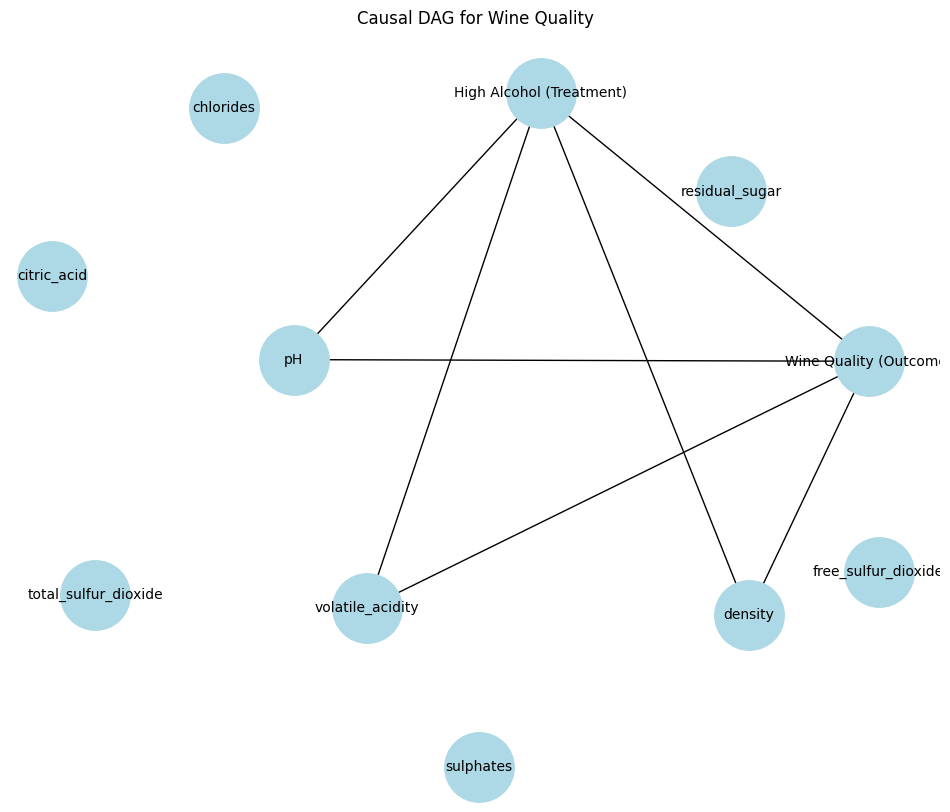

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

# Selected covariates based on feature selection and domain knowledge
selected_covariates = [
    'volatile_acidity', 
    'citric_acid', 
    'residual_sugar', 
    'chlorides', 
    'free_sulfur_dioxide', 
    'total_sulfur_dioxide', 
    'pH', 
    'sulphates', 
    'density'
]

# Create a directed graph (DAG)
dag = nx.DiGraph()

# Add nodes: 'T' for treatment, 'Y' for outcome, plus the selected covariates
dag.add_node('T', label='High Alcohol (Treatment)')
dag.add_node('Y', label='Wine Quality (Outcome)')
for cov in selected_covariates:
    dag.add_node(cov, label=cov)

# Add edges representing assumed causal relationships:
dag.add_edge('T', 'Y')
dag.add_edge('volatile_acidity', 'T')
dag.add_edge('volatile_acidity', 'Y')
dag.add_edge('pH', 'T')
dag.add_edge('pH', 'Y')
dag.add_edge('density', 'T')
dag.add_edge('density', 'Y')

# Increase figure size
plt.figure(figsize=(12, 10))

# Use spring_layout with a larger k-value to spread out the nodes
pos = nx.spring_layout(dag, seed=42, k=2.0, iterations=50)

# Extract labels from node attributes
node_labels = nx.get_node_attributes(dag, 'label')

# Draw the nodes and edges separately
nx.draw_networkx_nodes(dag, pos, node_size=2500, node_color='lightblue')
nx.draw_networkx_edges(dag, pos, arrows=True, arrowstyle='->', arrowsize=20)

# Draw labels in a separate step (can adjust font_size and offset if needed)
nx.draw_networkx_labels(dag, pos, labels=node_labels, font_size=10)

plt.title("Causal DAG for Wine Quality")
plt.axis('off')  # Hide axis for a cleaner look
plt.show()


## Code Explanation above

1. **Selected Covariates:**  
   A list of covariates (`selected_covariates`) is defined based on feature selection results and domain knowledge. These will be included in the causal graph as nodes.

2. **Directed Graph (DAG) Creation:**  
   - `nx.DiGraph()` creates a directed graph in NetworkX.
   - Two special nodes are added:
     - `'T'` representing **High Alcohol (Treatment)**
     - `'Y'` representing **Wine Quality (Outcome)**
   - Each covariate in `selected_covariates` is also added as a node, with a `label` attribute for more descriptive text.

3. **Adding Edges (Causal Relationships):**  
   - Edges are added to reflect the assumed causal paths.  
   - For instance, `'T' -> 'Y'` indicates that high alcohol (treatment) has a direct causal effect on wine quality (outcome).  
   - Covariates like `volatile_acidity`, `pH`, and `density` are hypothesized to influence both `'T'` and `'Y'`, suggesting they could act as confounders if not properly controlled.

4. **Graph Layout and Drawing:**  
   - `plt.figure(figsize=(12, 10))` sets a larger figure size for better readability.  
   - `nx.spring_layout(...)` arranges nodes using a force-directed algorithm, with a higher `k` value and more iterations to spread out the nodes.  
   - Nodes, edges, and labels are drawn in separate commands to allow for customization (e.g., node size, color, font size).  
   - `plt.axis('off')` hides the coordinate axes for a cleaner look.

### Output Explanation

The resulting **Causal DAG** shows:

- **Treatment Node** (High Alcohol) at the top center, labeled “High Alcohol (Treatment).”
- **Outcome Node** (Wine Quality) typically placed toward the right, labeled “Wine Quality (Outcome).”
- **Covariate Nodes** arranged around the graph, each labeled with its name (e.g., `volatile_acidity`, `pH`, `density`).

Arrows (`->`) illustrate the assumed direction of causal influence. For instance:
- An arrow from `T` to `Y` indicates the direct effect of high alcohol content on wine quality.
- Arrows from certain covariates (e.g., `pH`) to both `T` and `Y` highlight the possibility that these variables could confound the relationship between treatment and outcome if not controlled.

This visual representation helps clarify the hypothesized causal structure, guiding which variables should be included in the model to estimate an unbiased effect of high alcohol on wine quality.



Regression formula:
quality ~ high_alcohol + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + pH + sulphates + density

Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     75.77
Date:                Mon, 31 Mar 2025   Prob (F-statistic):          5.56e-127
Time:                        18:56:59   Log-Likelihood:                -1614.7
No. Observations:                1599   AIC:                             3251.
Df Residuals:                    1588   BIC:                             3311.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
           

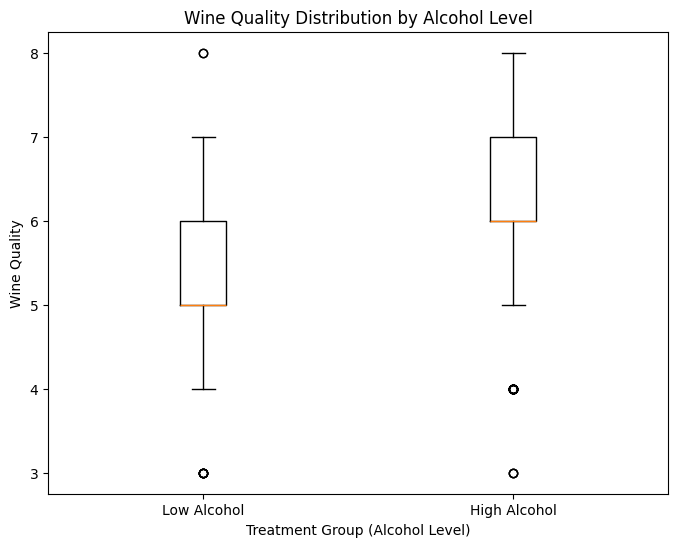

In [18]:
# Step 4: Estimate the Causal Effect Using OLS Regression
# Build the regression formula using our treatment and selected covariates.
formula = "quality ~ high_alcohol + " + " + ".join(selected_covariates)
print("\nRegression formula:")
print(formula)

# Fit the OLS regression model
model = smf.ols(formula, data=wine).fit()
print("\nRegression Summary:")
print(model.summary())

# Optional: Visualize the outcome distribution by treatment status
plt.figure(figsize=(8, 6))
plt.boxplot([wine.loc[wine['high_alcohol'] == 0, 'quality'],
             wine.loc[wine['high_alcohol'] == 1, 'quality']],
            labels=['Low Alcohol', 'High Alcohol'])
plt.xlabel('Treatment Group (Alcohol Level)')
plt.ylabel('Wine Quality')
plt.title('Wine Quality Distribution by Alcohol Level')
plt.show()

## Code Explanation above

1. **Building the Regression Formula**  
   - The formula includes the outcome variable (`quality`), the treatment variable (`high_alcohol`), and the selected covariates (e.g., `volatile_acidity`, `pH`, `density`).  
   - By controlling for these covariates, we aim to isolate the effect of high alcohol content on wine quality.

2. **Fitting the Model**  
   - We use an OLS (Ordinary Least Squares) regression via `statsmodels.formula.api.ols()`.  
   - `model.summary()` provides details on how well the model fits the data and the estimated coefficients.

3. **Visualizing the Outcome Distribution by Treatment Status**  
   - The boxplot compares wine quality between the low-alcohol group and the high-alcohol group.  
   - This visual helps illustrate any differences in the distribution of quality between the two treatment groups.

### Output Explanation

1. **Regression Formula** 
    - quality ~ high_alcohol + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + pH + sulphates + density
    - This formula indicates that `quality` is modeled as a function of the binary treatment (`high_alcohol`) plus the listed covariates.

2. **OLS Regression Summary**  
- **R-squared (0.323)**: Approximately 32.3% of the variance in wine quality is explained by the model.  
- **Coefficient on `high_alcohol` (0.3668)**: Interpreted as, on average, having a high alcohol content is associated with an increase of about 0.37 points in wine quality, holding the other covariates constant.  
- **Statistical Significance**: The p-value for `high_alcohol` is extremely small (p < 0.0001), suggesting a statistically significant relationship.  
- **Coefficients for Covariates**: Some (e.g., `volatile_acidity`) are negatively associated with quality, while others (e.g., `residual_sugar`) show a positive relationship.

3. **Boxplot of Wine Quality by Alcohol Level**  
- The boxplot visually compares wine quality scores between low- and high-alcohol groups.  
- The median quality score is higher in the high-alcohol group, which aligns with the positive coefficient estimated in the regression.  
- Outliers and the spread of values can also be observed, indicating that while there is an overall difference, individual wines vary considerably within each group.

Overall, this analysis suggests that, after controlling for the selected covariates, high alcohol content has a positive and statistically significant effect on wine quality. However, further causal inference methods (e.g., propensity score matching, instrumental variables) could be explored to strengthen causal claims, depending on the study’s assumptions and goals.



## Conclusion

In this notebook, we demonstrated a step-by-step causal inference analysis on the Wine Quality dataset. The key takeaways include:

- **Data Preparation:**  
  Properly cleaning and preparing the data (e.g., handling column names and creating a treatment variable) is crucial for accurate modeling and interpretation.

- **Feature Selection:**  
  Using both exploratory data analysis (via a correlation matrix) and a data-driven approach (Lasso regression) helps identify important covariates that may confound the relationship between the treatment and outcome.

- **Causal Structure (DAG):**  
  Constructing a Directed Acyclic Graph (DAG) with NetworkX clarifies our assumptions about the relationships between the treatment, outcome, and covariates, guiding the model specification.

- **Causal Effect Estimation:**  
  Estimating the effect of high alcohol content on wine quality using OLS regression, while controlling for confounding variables, enables a more robust interpretation of the treatment effect.

Overall, this analysis underscores the importance of thorough data preparation and thoughtful model development in causal inference. These practices ensure that conclusions drawn from machine learning models are both interpretable and robust.

## References

- UCI Machine Learning Repository, Wine Quality Dataset: [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)
- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). *Scikit-learn: Machine Learning in Python*. Journal of Machine Learning Research, 12, 2825-2830.
- Seaborn: [Seaborn: Statistical Data Visualization](https://seaborn.pydata.org/)
- Statsmodels: [Statsmodels: Statistical Modeling](https://www.statsmodels.org/)
- ChatGPT, OpenAI's language model (2023-2024) for assistance with explanations and code examples.

## License

This notebook and its accompanying content are provided under the MIT License. You are free to use, modify, and distribute the content, provided that appropriate credit is given and this license is included in any copies or substantial portions of the work.
